# CatBoost on MalbehavD-V1

Exploring the claims of CatBoost to use categorical data.

# 0. Import Libraries

In [1]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split #For Splitting Datasets
from sklearn import preprocessing #For LabelEncoding
from sklearn.metrics import classification_report #For Classification Report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #For Confusion Matrix
import matplotlib.pyplot as plt #For figure plotting.
from sklearn.model_selection import RandomizedSearchCV #For automated hyperparameter tuning; Would be better if it was GridSearchCV
from sklearn.preprocessing import LabelEncoder
import imblearn
import lightgbm as lgbm
import catboost as catb
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTEN

# 1. Import Dataset

In [2]:
malbd = pd.read_csv("malbd.csv")
malbd

,sha256,labels,0,1,2,3,4,5,6,7,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,ed6a3fc04af435176b9c2f3024eb53c31d1e522da52c5c...,1,CreateToolhelp32Snapshot,GetCursorPos,CoUninitialize,RegCloseKey,LdrUnloadDll,DrawTextExW,NtSetInformationFile,CopyFileA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2566,ed5d70a13633a46355c0c2f9905ba29b7b74dfdb4db321...,1,NtDuplicateObject,RegCloseKey,LdrUnloadDll,NtSetInformationFile,RegQueryValueExA,NtTerminateProcess,NtQueryValueKey,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,ed5addbdbe5f56f108530148c71ab7db806ac9324395d0...,1,GetCursorPos,NtOpenSection,CoUninitialize,RegCloseKey,LdrUnloadDll,GetSystemInfo,RegQueryValueExA,NtTerminateProcess,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2568,ed4f4518e3120a4fd8ff6c61bf072d4de60264711a9196...,1,NtAllocateVirtualMemory,LdrGetProcedureAddress,SetUnhandledExceptionFilter,GetFileType,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetDllHandle,NtProtectVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Cleaning Dataset

In [3]:
#Fixing column labels
new_col_name = ['sha256','labels']
for i in range(0,175):
    new_col_name.append(str(i))
malbd.columns = new_col_name

#Removing sha256 column
malbd.drop('sha256', axis=1, inplace=True)

#Fill NaN values with space
malbd.fillna(value=' ', inplace=True)

malbd.head()

,labels,0,1,2,3,4,5,6,7,8,...,165,166,167,168,169,170,171,172,173,174
0,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,...,,,,,,,,,,
1,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,NtQueryValueKey,...,,,,,,,,,,
2,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,RegQueryValueExW,...,,,,,,,,,,
3,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,,,,,,,,,,
4,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,NtQueryAttributesFile,...,,,,,,,,,,


# 3. CatBoost

*Only a simple test will be done. No tuning, just running.*

In [4]:
#Splitting datasets to train and test datasets
X,y = malbd.iloc[:,1:],malbd['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [5]:
#Loading CatBoost Classifer as an object
catbClassifier = catb.CatBoostClassifier(thread_count=-1, random_state=1, learning_rate=0.1, n_estimators=1000, 
                                         cat_features=malbd.columns[1:].to_list(), verbose=1, boosting_type='Plain', 
                                         grow_policy='Lossguide')

#Training model
#Training model
start = time.time()
catbClassifier.fit(X_train, y_train)
print("Train Time:", time.time()-start, "seconds")

0:	learn: 0.6422639	total: 382ms	remaining: 6m 21s
1:	learn: 0.5819466	total: 619ms	remaining: 5m 8s
2:	learn: 0.5396550	total: 846ms	remaining: 4m 41s
3:	learn: 0.4965462	total: 1.08s	remaining: 4m 28s
4:	learn: 0.4710174	total: 1.3s	remaining: 4m 19s
5:	learn: 0.4435664	total: 1.57s	remaining: 4m 19s
6:	learn: 0.4252839	total: 1.86s	remaining: 4m 23s
7:	learn: 0.4076307	total: 2.11s	remaining: 4m 21s
8:	learn: 0.3915452	total: 2.42s	remaining: 4m 27s
9:	learn: 0.3780360	total: 2.67s	remaining: 4m 24s
10:	learn: 0.3611096	total: 2.94s	remaining: 4m 24s
11:	learn: 0.3473756	total: 3.2s	remaining: 4m 23s
12:	learn: 0.3361970	total: 3.47s	remaining: 4m 23s
13:	learn: 0.3253937	total: 3.77s	remaining: 4m 25s
14:	learn: 0.3178704	total: 4.04s	remaining: 4m 25s
15:	learn: 0.3111528	total: 4.27s	remaining: 4m 22s
16:	learn: 0.3046634	total: 4.56s	remaining: 4m 23s
17:	learn: 0.2969725	total: 4.83s	remaining: 4m 23s
18:	learn: 0.2913409	total: 5.09s	remaining: 4m 22s
19:	learn: 0.2864091	tota

159:	learn: 0.1096645	total: 39.8s	remaining: 3m 29s
160:	learn: 0.1090238	total: 40.1s	remaining: 3m 28s
161:	learn: 0.1082163	total: 40.3s	remaining: 3m 28s
162:	learn: 0.1077797	total: 40.6s	remaining: 3m 28s
163:	learn: 0.1077352	total: 40.8s	remaining: 3m 27s
164:	learn: 0.1069337	total: 41.1s	remaining: 3m 27s
165:	learn: 0.1064829	total: 41.4s	remaining: 3m 27s
166:	learn: 0.1060226	total: 41.7s	remaining: 3m 27s
167:	learn: 0.1056149	total: 41.9s	remaining: 3m 27s
168:	learn: 0.1051276	total: 42.1s	remaining: 3m 27s
169:	learn: 0.1047832	total: 42.3s	remaining: 3m 26s
170:	learn: 0.1043204	total: 42.6s	remaining: 3m 26s
171:	learn: 0.1037345	total: 42.8s	remaining: 3m 26s
172:	learn: 0.1027179	total: 43.1s	remaining: 3m 25s
173:	learn: 0.1021165	total: 43.3s	remaining: 3m 25s
174:	learn: 0.1016539	total: 43.5s	remaining: 3m 25s
175:	learn: 0.1012868	total: 43.7s	remaining: 3m 24s
176:	learn: 0.1006789	total: 44s	remaining: 3m 24s
177:	learn: 0.1003812	total: 44.2s	remaining: 3m

315:	learn: 0.0575857	total: 1m 18s	remaining: 2m 49s
316:	learn: 0.0574612	total: 1m 18s	remaining: 2m 48s
317:	learn: 0.0574060	total: 1m 18s	remaining: 2m 48s
318:	learn: 0.0572350	total: 1m 18s	remaining: 2m 48s
319:	learn: 0.0569868	total: 1m 18s	remaining: 2m 47s
320:	learn: 0.0568496	total: 1m 19s	remaining: 2m 47s
321:	learn: 0.0566407	total: 1m 19s	remaining: 2m 47s
322:	learn: 0.0565268	total: 1m 19s	remaining: 2m 46s
323:	learn: 0.0563382	total: 1m 19s	remaining: 2m 46s
324:	learn: 0.0560950	total: 1m 19s	remaining: 2m 45s
325:	learn: 0.0554698	total: 1m 20s	remaining: 2m 45s
326:	learn: 0.0552790	total: 1m 20s	remaining: 2m 45s
327:	learn: 0.0551878	total: 1m 20s	remaining: 2m 44s
328:	learn: 0.0549401	total: 1m 20s	remaining: 2m 44s
329:	learn: 0.0547563	total: 1m 20s	remaining: 2m 44s
330:	learn: 0.0544650	total: 1m 21s	remaining: 2m 44s
331:	learn: 0.0542986	total: 1m 21s	remaining: 2m 44s
332:	learn: 0.0540628	total: 1m 21s	remaining: 2m 43s
333:	learn: 0.0538792	total:

469:	learn: 0.0382826	total: 1m 50s	remaining: 2m 4s
470:	learn: 0.0381200	total: 1m 50s	remaining: 2m 4s
471:	learn: 0.0380702	total: 1m 50s	remaining: 2m 3s
472:	learn: 0.0379680	total: 1m 50s	remaining: 2m 3s
473:	learn: 0.0378239	total: 1m 51s	remaining: 2m 3s
474:	learn: 0.0378202	total: 1m 51s	remaining: 2m 2s
475:	learn: 0.0377381	total: 1m 51s	remaining: 2m 2s
476:	learn: 0.0375935	total: 1m 51s	remaining: 2m 2s
477:	learn: 0.0375328	total: 1m 52s	remaining: 2m 2s
478:	learn: 0.0374629	total: 1m 52s	remaining: 2m 2s
479:	learn: 0.0374065	total: 1m 52s	remaining: 2m 1s
480:	learn: 0.0371148	total: 1m 52s	remaining: 2m 1s
481:	learn: 0.0371081	total: 1m 52s	remaining: 2m 1s
482:	learn: 0.0370948	total: 1m 53s	remaining: 2m 1s
483:	learn: 0.0370208	total: 1m 53s	remaining: 2m
484:	learn: 0.0370205	total: 1m 53s	remaining: 2m
485:	learn: 0.0369631	total: 1m 53s	remaining: 2m
486:	learn: 0.0369631	total: 1m 53s	remaining: 1m 59s
487:	learn: 0.0368996	total: 1m 53s	remaining: 1m 59s


623:	learn: 0.0276081	total: 2m 22s	remaining: 1m 26s
624:	learn: 0.0275220	total: 2m 23s	remaining: 1m 25s
625:	learn: 0.0273172	total: 2m 23s	remaining: 1m 25s
626:	learn: 0.0272359	total: 2m 23s	remaining: 1m 25s
627:	learn: 0.0271981	total: 2m 23s	remaining: 1m 25s
628:	learn: 0.0271739	total: 2m 24s	remaining: 1m 24s
629:	learn: 0.0271739	total: 2m 24s	remaining: 1m 24s
630:	learn: 0.0271661	total: 2m 24s	remaining: 1m 24s
631:	learn: 0.0270641	total: 2m 24s	remaining: 1m 24s
632:	learn: 0.0269982	total: 2m 24s	remaining: 1m 23s
633:	learn: 0.0269719	total: 2m 24s	remaining: 1m 23s
634:	learn: 0.0269632	total: 2m 25s	remaining: 1m 23s
635:	learn: 0.0269436	total: 2m 25s	remaining: 1m 23s
636:	learn: 0.0269436	total: 2m 25s	remaining: 1m 22s
637:	learn: 0.0269401	total: 2m 25s	remaining: 1m 22s
638:	learn: 0.0269357	total: 2m 25s	remaining: 1m 22s
639:	learn: 0.0269134	total: 2m 25s	remaining: 1m 21s
640:	learn: 0.0268949	total: 2m 25s	remaining: 1m 21s
641:	learn: 0.0268829	total:

777:	learn: 0.0216863	total: 2m 53s	remaining: 49.5s
778:	learn: 0.0216838	total: 2m 53s	remaining: 49.2s
779:	learn: 0.0216742	total: 2m 53s	remaining: 49s
780:	learn: 0.0216742	total: 2m 53s	remaining: 48.7s
781:	learn: 0.0216741	total: 2m 53s	remaining: 48.5s
782:	learn: 0.0216740	total: 2m 54s	remaining: 48.2s
783:	learn: 0.0216740	total: 2m 54s	remaining: 48s
784:	learn: 0.0216721	total: 2m 54s	remaining: 47.8s
785:	learn: 0.0216708	total: 2m 54s	remaining: 47.5s
786:	learn: 0.0216705	total: 2m 54s	remaining: 47.3s
787:	learn: 0.0216693	total: 2m 54s	remaining: 47s
788:	learn: 0.0216635	total: 2m 55s	remaining: 46.8s
789:	learn: 0.0216634	total: 2m 55s	remaining: 46.6s
790:	learn: 0.0216357	total: 2m 55s	remaining: 46.3s
791:	learn: 0.0216349	total: 2m 55s	remaining: 46.1s
792:	learn: 0.0216349	total: 2m 55s	remaining: 45.8s
793:	learn: 0.0216320	total: 2m 55s	remaining: 45.6s
794:	learn: 0.0216196	total: 2m 55s	remaining: 45.4s
795:	learn: 0.0216073	total: 2m 56s	remaining: 45.1s

935:	learn: 0.0192683	total: 3m 21s	remaining: 13.8s
936:	learn: 0.0192662	total: 3m 21s	remaining: 13.5s
937:	learn: 0.0192623	total: 3m 21s	remaining: 13.3s
938:	learn: 0.0192623	total: 3m 21s	remaining: 13.1s
939:	learn: 0.0192295	total: 3m 21s	remaining: 12.9s
940:	learn: 0.0192225	total: 3m 21s	remaining: 12.7s
941:	learn: 0.0192225	total: 3m 21s	remaining: 12.4s
942:	learn: 0.0192225	total: 3m 22s	remaining: 12.2s
943:	learn: 0.0192170	total: 3m 22s	remaining: 12s
944:	learn: 0.0192169	total: 3m 22s	remaining: 11.8s
945:	learn: 0.0192069	total: 3m 22s	remaining: 11.6s
946:	learn: 0.0192066	total: 3m 22s	remaining: 11.3s
947:	learn: 0.0191925	total: 3m 22s	remaining: 11.1s
948:	learn: 0.0191835	total: 3m 23s	remaining: 10.9s
949:	learn: 0.0191835	total: 3m 23s	remaining: 10.7s
950:	learn: 0.0191834	total: 3m 23s	remaining: 10.5s
951:	learn: 0.0191834	total: 3m 23s	remaining: 10.3s
952:	learn: 0.0191781	total: 3m 23s	remaining: 10.1s
953:	learn: 0.0191691	total: 3m 23s	remaining: 9

C:\Users\ejose\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\ejose\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


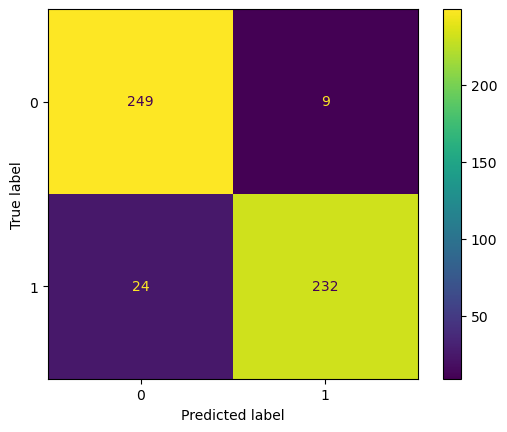

              precision    recall  f1-score   support

           0     0.9121    0.9651    0.9379       258
           1     0.9627    0.9062    0.9336       256

    accuracy                         0.9358       514
   macro avg     0.9374    0.9357    0.9357       514
weighted avg     0.9373    0.9358    0.9357       514



C:\Users\ejose\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\ejose\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [6]:
#Testing Predictions
y_pred = catbClassifier.predict(X_test)

#Create confusion matrix
catb_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=catb_cm)
disp.plot()
plt.show()

#Create classification report
catb_cr = classification_report(y_test, y_pred, digits=4)
print(catb_cr)